[nltk_data] Downloading package stopwords to /Users/nigel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading the JSON file...


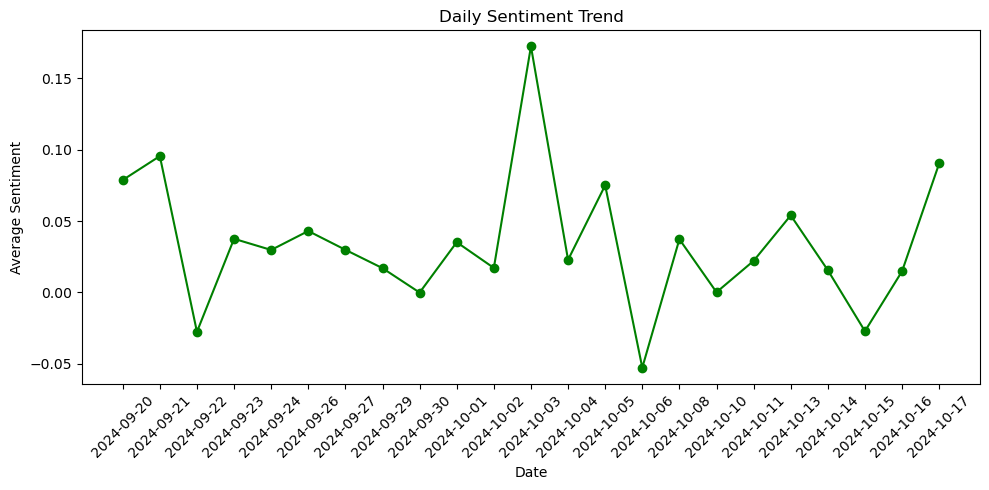

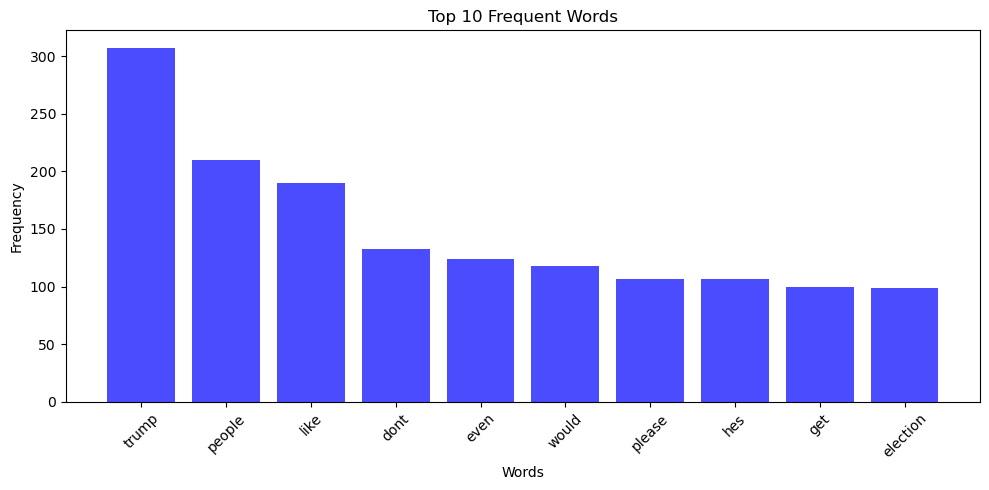

Total number of posts: 26
Total number of comments (including replies): 1384


In [14]:
import json
import re
import matplotlib.pyplot as plt
from textblob import TextBlob
from collections import defaultdict, Counter
from datetime import datetime
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load the JSON file
print("Loading the JSON file...")
with open('r_politics_top_daily_posts_and_comments.json', 'r') as f:
    data = json.load(f)

# Clean and preprocess text
def clean_text(text):
    # Remove URLs, special characters, and numbers
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.lower()  # Convert to lowercase
    return text

# Word count function
def count_words(text):
    words = clean_text(text).split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return words

# Sentiment analysis function using TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Sentiment polarity (-1 to 1)

# Lists to store sentiment per day and word frequencies
daily_sentiment = defaultdict(list)
word_frequencies = Counter()

# Variables to count posts and comments
total_posts = 0
total_comments = 0

# Iterate over the scraped data
for post in data:
    total_posts += 1  # Count the post
    # Count words and sentiment for post title
    post_words = count_words(post['title'])
    post_sentiment = get_sentiment(post['title'])
    
    # Update word frequencies for the post title
    word_frequencies.update(post_words)
    
    # Convert the post's UTC timestamp to a readable date
    post_date = datetime.utcfromtimestamp(post['created_utc']).strftime('%Y-%m-%d')
    
    # Store the sentiment for the post
    daily_sentiment[post_date].append(post_sentiment)
    
    # Process comments and their replies
    for comment in post.get('comments', []):
        total_comments += 1  # Count the comment
        comment_words = count_words(comment['body'])
        comment_sentiment = get_sentiment(comment['body'])
        word_frequencies.update(comment_words)
        daily_sentiment[post_date].append(comment_sentiment)
        
        # Process replies
        for reply in comment.get('replies', []):
            total_comments += 1  # Count the reply as a comment
            reply_words = count_words(reply['body'])
            reply_sentiment = get_sentiment(reply['body'])
            word_frequencies.update(reply_words)
            daily_sentiment[post_date].append(reply_sentiment)

# Calculate the average daily sentiment
avg_daily_sentiment = {date: sum(sentiments) / len(sentiments) for date, sentiments in daily_sentiment.items()}

# Sort daily sentiment by date
sorted_dates = sorted(avg_daily_sentiment.keys())
sorted_sentiments = [avg_daily_sentiment[date] for date in sorted_dates]

# Plot the daily sentiment trend
plt.figure(figsize=(10, 5))
plt.plot(sorted_dates, sorted_sentiments, marker='o', color='green')
plt.title('Daily Sentiment Trend')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the top 10 frequent words
top_10_words = word_frequencies.most_common(10)
words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='blue', alpha=0.7)
plt.title('Top 10 Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the total number of posts and comments
print(f"Total number of posts: {total_posts}")
print(f"Total number of comments (including replies): {total_comments}")

In [13]:
top_10_words

[('trump', 307),
 ('people', 210),
 ('like', 190),
 ('dont', 133),
 ('even', 124),
 ('would', 118),
 ('please', 107),
 ('hes', 107),
 ('get', 100),
 ('election', 99)]